# MRegime Prediction with Machine Learning - ML Prediction

In this part we are going to predict recessions with machine learning algorithms in ```scikit-learn``` package.

&nbsp;&nbsp;1. [Model Framework](#1)
   
&nbsp;&nbsp;2. [Data and Set-up](#2)

&nbsp;&nbsp;3. [Cross-Validation](#3)

&nbsp;&nbsp;4. [Out-of-sample Prediction](#4)


## 1. Model Framework

**Machine Learning Models**

Here, we look at regime modeling problem from an algorithmic approach and seek a function $f$ that approximates the relationship between feature matrix $X$ and regime labels $y$.
In order to understand dynamics, we explore both linear and nonlinear classifiers with ensembles for regime prediction.

_(i) Linear Models_ Logit and probit models are the most common linear models for classification problems. The main difference is the choice of a cumulative distribution function. Probit assumes standard normal variable, whereas logistic uses standard logistically distributed random variable for distribution specification. Early works on business cycle forecasting employ these models. We consider logistic regression along with $\ell_1$ and $\ell_2$ regularization terms to test linear dynamics.

_(ii) Nonlinear Models_
Decision trees present one of the most successful non-parametric methods in ML applications in regression and classification problems. CART (Classification and Regression Trees) builds decision trees by recursively partitioning the feature space and assigns a label or class probabilities to each space for classification problems. CART takes a top-down approach by solving an optimization problem to find the best split at each node. Decision trees can capture nonlinear relationships in data and are interpretable over other ML methods. However, there are disadvantages: Their greedy nature leads to less accurate classifiers and a single decision tree is sensitive to training data. 



**Evaluation Metrics**

The model outputs are received in two forms: probability forecasts and binary classification of regime states. We consider multiple error metrics to evaluate a classification model performance.  A natural metric is classification accuracy (ACC). For given probability prediction for positive state $\hat{y}_t$ and binary label of the original state $y_t$
 
\begin{equation}
    ACC=\frac{1}{T}\sum_{t=1}^T \left[ {1}_{\{\hat{y}_t \geq c\}}y_t +(1-{1}_{\{\hat{y}_t \geq c\}}) (1-y_t) \right]
\end{equation}

where $c$ is the threshold to get regime states which is set to natural choice of 50\%.
State probability forecasts are important inputs for the portfolio models and quadratic probability score (QPS) evaluates prediction performance in terms of probabilities. Notice that QPS does not evaluate classification ability. If two models have different probability outputs, they might have same ACC score but not same QPS which is mean squared error of probability forecasts.

\begin{equation}
    QPS = \frac{1}{T}\sum_{t=1}^T (\hat{y}_t-y_t)^2
\end{equation}

 In a perfect prediction setting, QPS equals 0. The lower the value of QPS, the better the model performance. Because of the imbalanced nature of the dataset we consider other evaluation metrics to avoid inflated error metrics. Receiver operating characteristic (ROC) curve  is a common choice in imbalanced classification problems. ROC curve plots true positive rate (recall) ($tpr=tp/tp+fn$) against false positive rate ($fpr=fp/fp+tn$) at various threshold settings.  Area under the ROC curve (AUC) generates summary statistic for ROC metric. In perfect prediction setting, ROC curve will be in inverted L-shape form with AUC metric 1. So the higher the AUC value, the better the model performance. The Matthew's Correlation Coefficient (MCC) is also reported as an evaluation metric  and deployed widely in the field of computational biology. MCC is calculated from the following
\begin{equation}
    MCC = \frac{tp \times tn - fp \times fn}{ \sqrt{(tp+fp)(tp+fn)(tn+fp)(tn+fn)}}
\end{equation}
In perfect prediction setting MCC equals 1 and the worst value is -1. Therefore the higher the MCC score the better the classification performance.

**Prediction Set-up**

The analysis covers the sample period from 1959 until August 2020. The historical performance period is split into two segments: 1) 1959 to 1973 is used for hyper parameter tuning, and 2) the period from 1973 until August 2020 for out-of-sample testing. 

ML models have two types of parameters: model parameters and hyper parameters. Model parameters can be learned from data but the hyper parameters need to be set in advance depending upon the model architecture. Important hyper parameters for the classifiers are regularization coefficient for logistic regression, depth of the trees, number of trees that are generated in ensembles, the maximum number of features considered in tree construction. Cross-validation is a common framework for hyper parameter tuning in the ML field. In the standard k-fold framework, training data is randomly grouped into k folds. In each iteration, model is trained on k-1 folds, and the remaining fold is used for validation. After k iteration, average of the model score is computed from validation sets. Since our dataset has a time series property, we implement the cross-validation to keep temporal dependency and avoid look ahead bias. We create $k$-folds as block of time periods, and move training and validation sets in a rolling basis. After the model hyper parameter optimization, out-of-sample predictions are performed in a rolling window basis with a length of 150 months. 

## 2. Data and Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import seaborn as sns

# Classification Functions and metrics form scikit-learn library
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import TimeSeriesSplit

from plot_regime import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))


def error_metrics(df, roc=False):
    """
    Four classification error metrics that will be used to evaluate model performance
    ACC: accuracy (0-1) loss
    QPS: quadratic probability score
    MCC: MAtthew's Correlation Coefficient
    AUC: Area under the ROC curve
    """
    mcc = matthews_corrcoef(y_true=df.Regime, y_pred=df.crash_binary)
    mis_rate = df[df.Regime != df.crash_binary].shape[0] / df.shape[0]
    qps = sum((df.crash_prob - df.Regime) ** 2) / len(df)
    err_dict = {'ACC': 1 - mis_rate,
                'MCC': mcc,
                'QPS': qps}
    if roc == True:
        roc = roc_auc_score(y_true=df.Regime, y_score=df.crash_prob)
        err_dict['AUC'] = roc

    return err_dict

In [3]:
df_macro = pd.read_csv('data/macro_processed.csv', parse_dates=['Date'])
# Regime column shows recession and expansion periods. (Recession label:1)
df_regime = pd.read_csv('data/recession_dates.csv',parse_dates = ['Date']) 
df = df_macro.merge(df_regime, on='Date',how='left')
# train and test set split date
split_date = '1973-01-01' 
df_train, df_test = df[df['Date'] < split_date], df[df['Date'] >= split_date]
target_col = 'Regime'
feature_col = df.columns.drop(['Regime', 'Date'])

## 3. Cross-Validation

In [5]:
# Model Parameters for Cross Validation - CAN BE CHANGED
# For more details on ML model parameters please refer to ```scikit-learn``` webpage.
# Use SIX different ML models
model_dict_cv = {('LR', LogisticRegression): {'solver': ['saga'],
                                                      'penalty': ['none'],
                                                      'max_iter': [100]},
                ('LR_l1', LogisticRegression): {'solver': ['saga'],
                                                         'max_iter': [100],
                                                         'penalty': ['l1'],
                                                         'C': [0.0001, 0.01, 0.1, 1, 10, 100]},
                ('LR_l2', LogisticRegression): {'solver': ['saga'],
                                                         'max_iter': [100],
                                                         'penalty': ['l2'],
                                                         'C': [0.0001, 0.01, 0.1, 1, 10, 100]},
                ('DT', DecisionTreeClassifier): {'max_depth': [3, 5, 8, 10],
                                                          'splitter': ['best', 'random'],
                                                          'min_samples_split': [2, 3, 5]},
                ('RF', RandomForestClassifier): {'random_state': [42],
                                                          'max_depth': [3, 5, 8, 10],
                                                          'n_estimators': [100,200,400],  
                                                          },
                ('XGB', xgb.XGBClassifier): {'booster': ['gbtree'],
                                                      'max_depth': [3, 5, 8, 10],
                                                      'n_estimators': [100,200,400],
                                                      'random_state': [42],
                                                      'objective': ['binary:logistic']}}
       

In [6]:
%%time
# This cell needs ~1.5 mins to run
scoring = 'ACC'
# keep selected parameters for each model
model_dict = {} 

for model_tuple, param_grid in model_dict_cv.items():
    all_grid = list(dict_product(param_grid))
    cv_res = []
    for param in all_grid:
        # timeseries split for cross validation
        tscv = TimeSeriesSplit(n_splits=3) 
        model = model_tuple[1](**param)
        score = []
        for train_index, test_index in tscv.split(df_train):
            X_train, X_test = df_train[feature_col].iloc[train_index], df_train[feature_col].iloc[test_index]
            y_train, y_test = df_train[target_col].iloc[train_index], df_train[target_col].iloc[test_index]
            date_train, date_test = df_train['Date'].iloc[train_index], df_train['Date'].iloc[test_index]
            model.fit(X_train, y_train)
            y_binary = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            res_dict = {'Date': date_test,
                        'Regime': y_test,
                        'crash_prob': y_prob,
                        'crash_binary': y_binary}
            res_df = pd.DataFrame.from_dict(res_dict)
            score.append(error_metrics(res_df)[scoring])
        cv_res.append(np.mean(score))
    best_param = all_grid[np.argmax(cv_res)]
    model_dict[model_tuple] = best_param

CPU times: total: 14min 28s
Wall time: 1min 33s


## 4. Out-of-sample Prediction

Out-of-sample predictions are performed on a rolling window basis. Model performances are evaluated with error metrics and recession prediction probabilities are visualized after that. 

In [9]:
%%time 
# this cell takes ~20 minutes to run
############## CAN BE CHANGED#######################
# Prediction window and horizon values
horizon_values = [0]
roll_window = 150
pred_window = 1
threshold = 0.5 # threshold for binary classification
#####################################################
k = 0
err_df_rolling = pd.DataFrame([])
for model_tuple, param in model_dict.items():
    t = df[df['Date'] == split_date].index.tolist()[0]
    df_pred = df.iloc[t - roll_window:, :]
    X = df_pred[feature_col]
    y = df_pred[target_col]
    date_range = df_pred['Date']
    y_prob = np.array([])
    date = np.array([], dtype='datetime64[s]')
    y_actual = np.array([])
    y_binary = np.array([])

    for i in np.arange(0, len(df_pred) - roll_window):
        model = model_tuple[1](**param)
        X_fit = X.iloc[i: i + roll_window, :]
        y_fit = y.iloc[i: i + roll_window]
        model = model.fit(X_fit, y_fit)
        X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
        y_pred = model.predict_proba(X_predict)[:, 1]
        # append class 1 probabilities
        y_prob = np.hstack((y_prob, y_pred))  
        y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
        date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
        y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

    res_model_df = pd.DataFrame.from_dict({'Date': date,
                                           'Regime': y_actual,
                                           'crash_prob': y_prob,
                                           'crash_binary': y_binary})
    if k == 0:
        res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                                  'Regime': y_actual,
                                                  model_tuple[0]: y_prob})
        k += 1
    else:
        res_rolling_all[model_tuple[0]] = y_prob

    err_dict = error_metrics(res_model_df, roc=True)
    err_dict['Model'] = model_tuple[0]
    err_df_rolling = pd.concat([err_df_rolling, pd.DataFrame([err_dict])])

CPU times: total: 1h 55min 28s
Wall time: 20min 31s


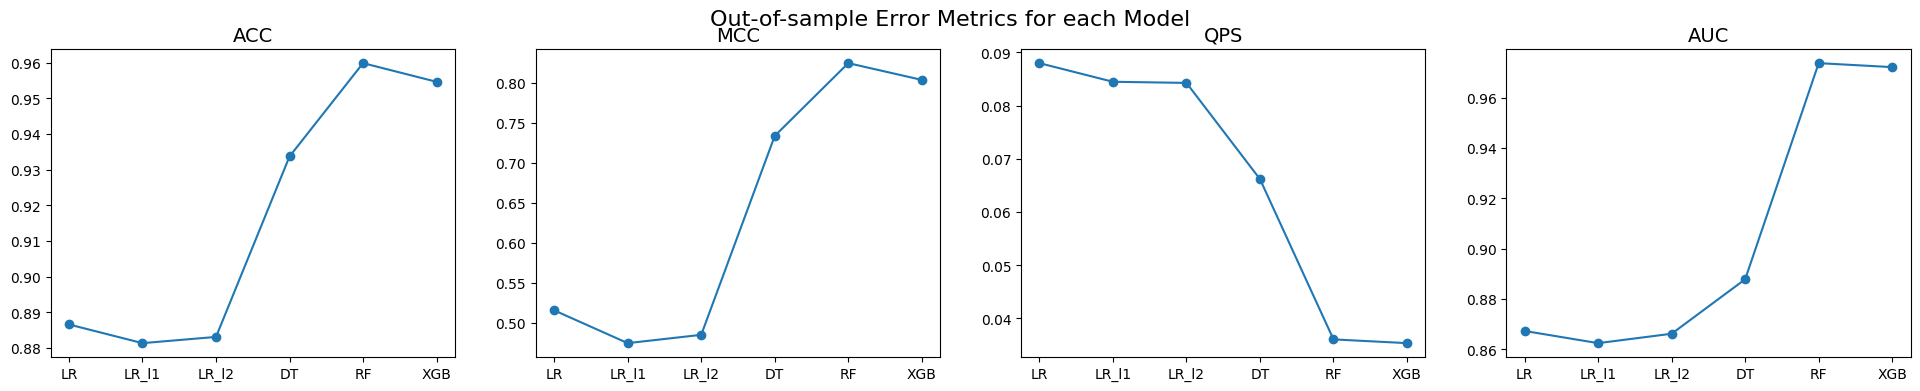

In [10]:
fig , axs = plt.subplots(1,4,figsize = (24,4))
for idx,name in enumerate(err_df_rolling.columns.drop('Model')):
    axs[idx].plot(err_df_rolling['Model'],err_df_rolling[name],marker ='o')
    axs[idx].set_title(name,fontsize =14)
plt.suptitle('Out-of-sample Error Metrics for each Model',fontsize =16)
plt.show()
# Random forest is the best

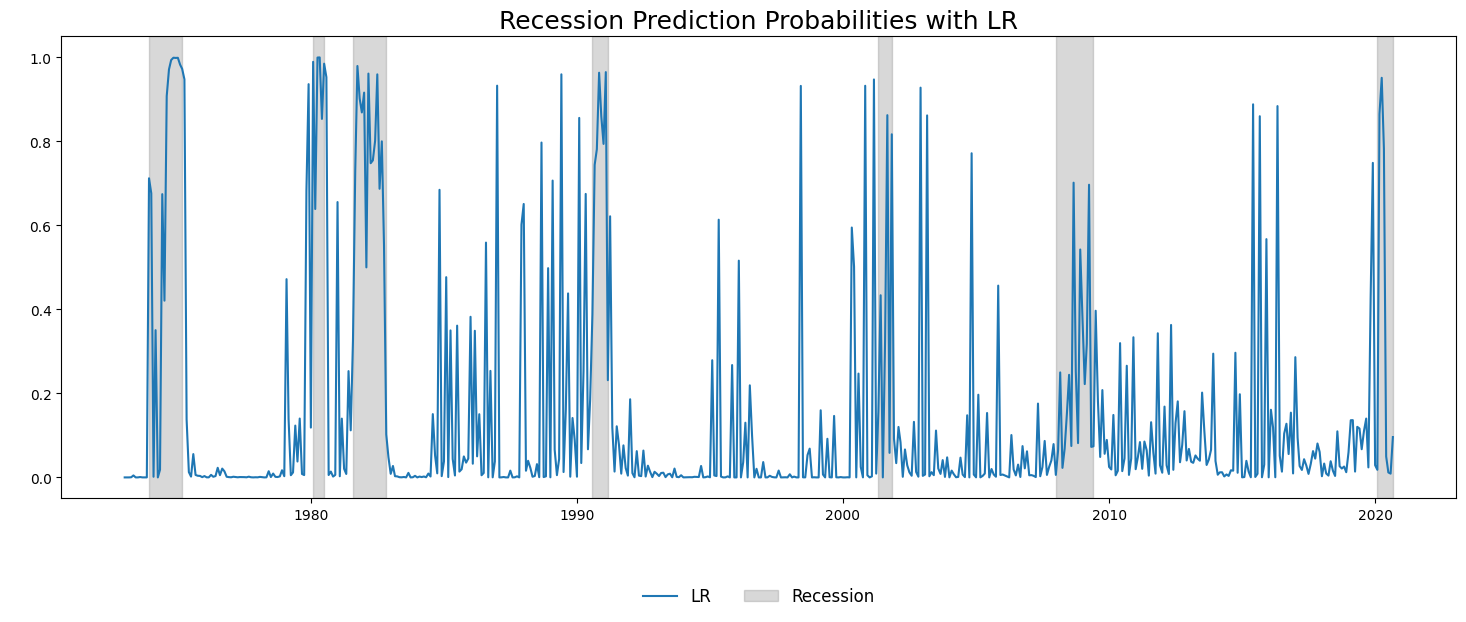

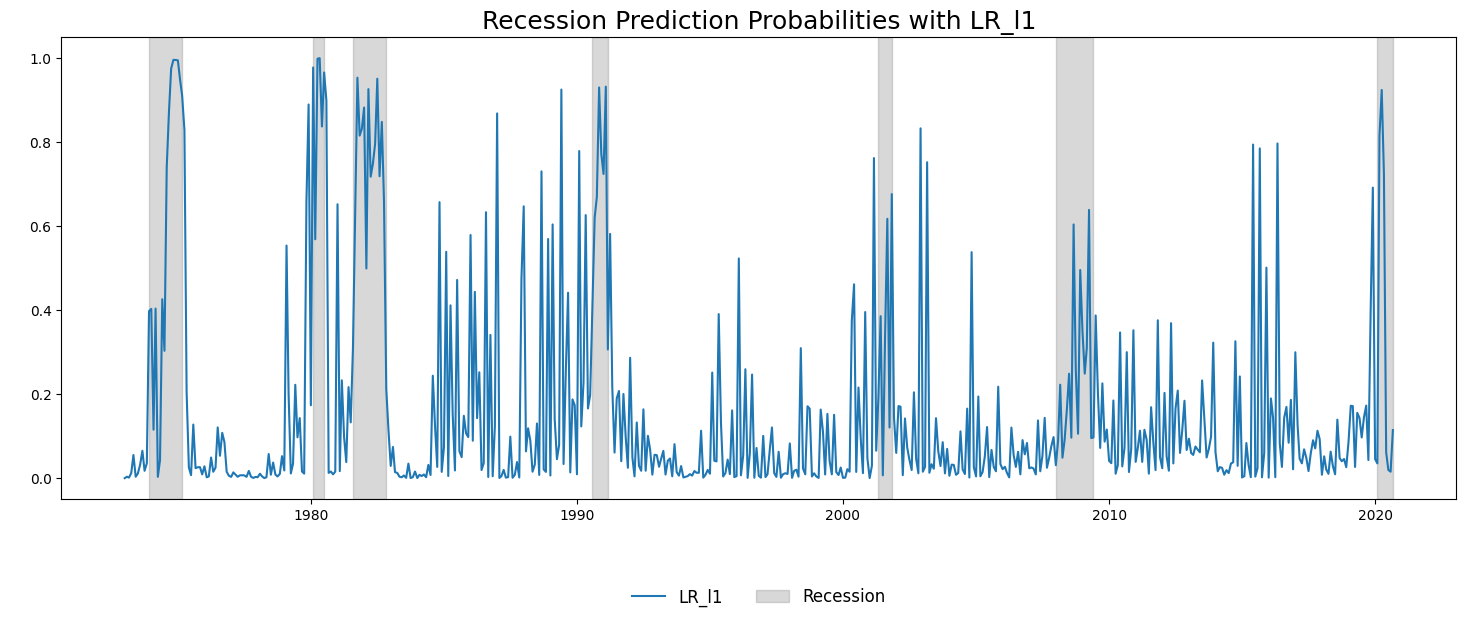

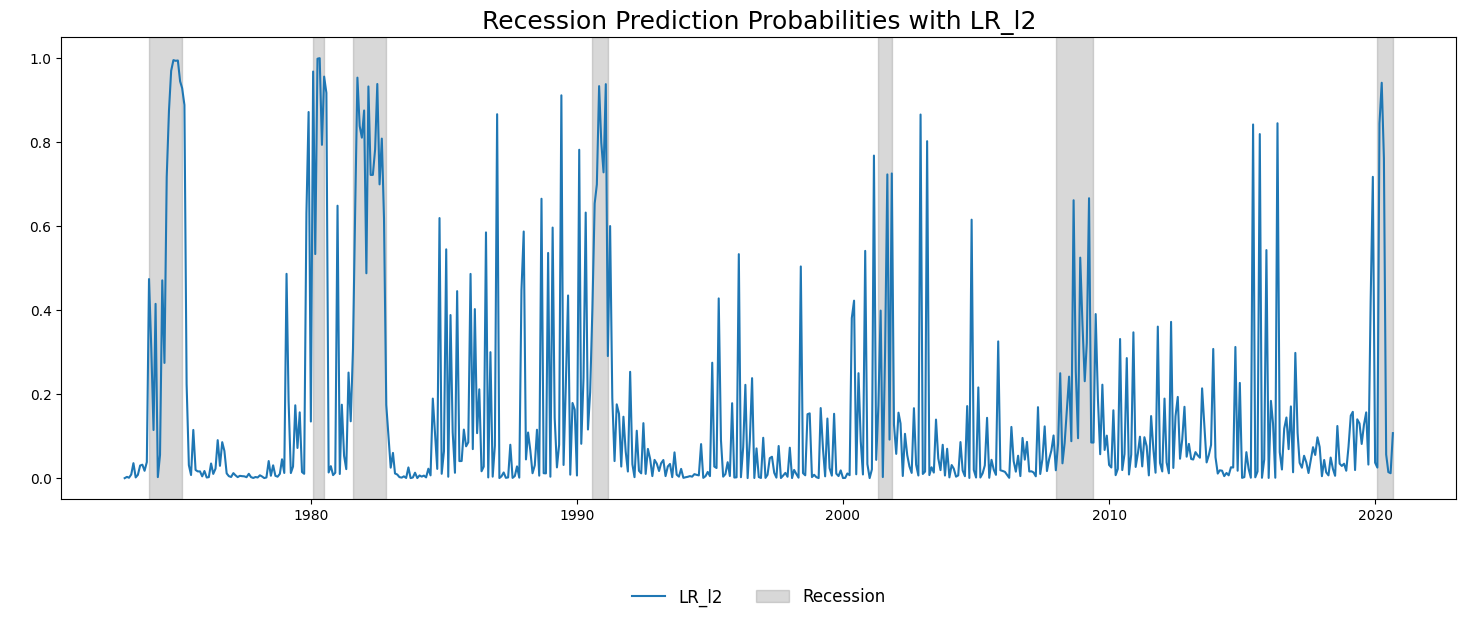

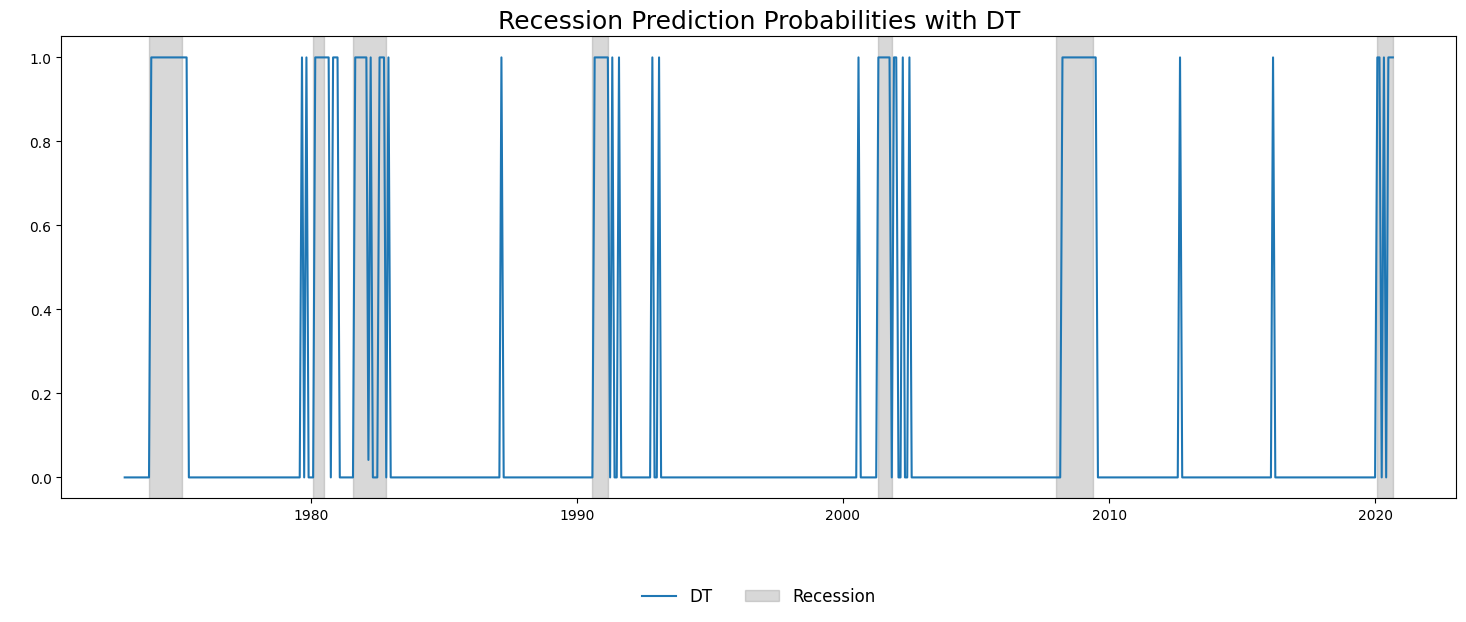

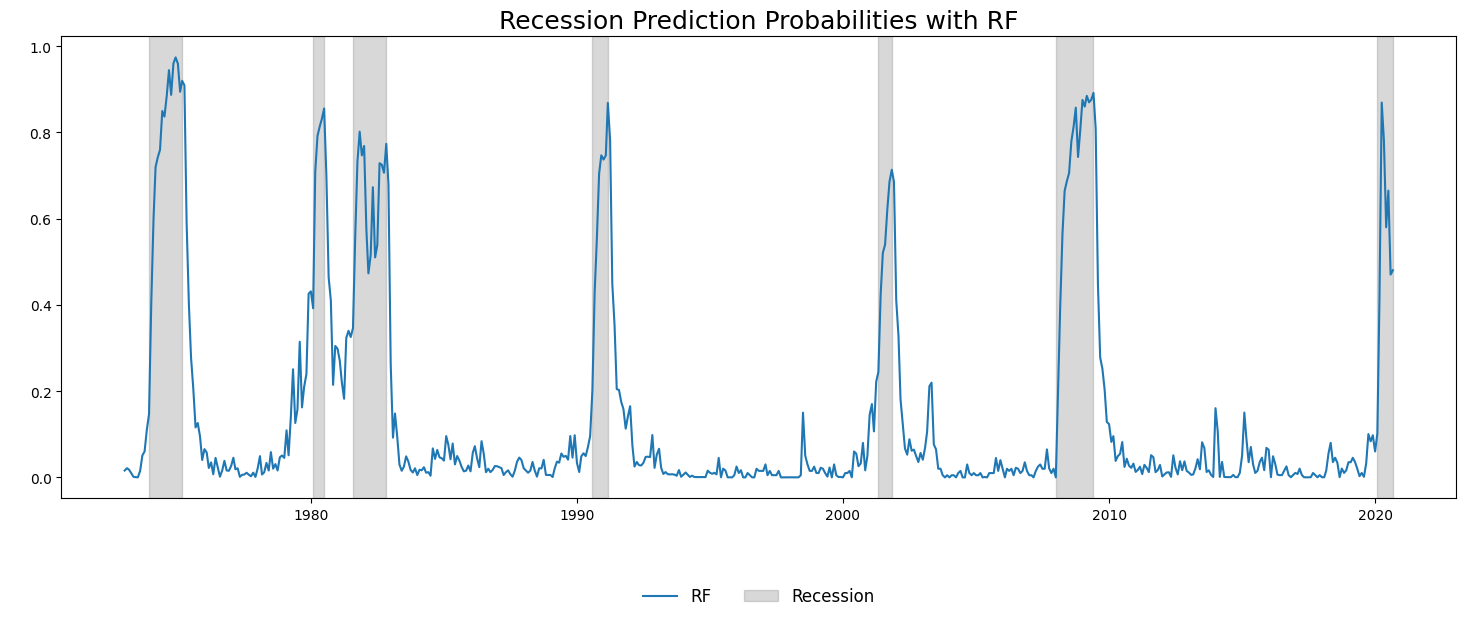

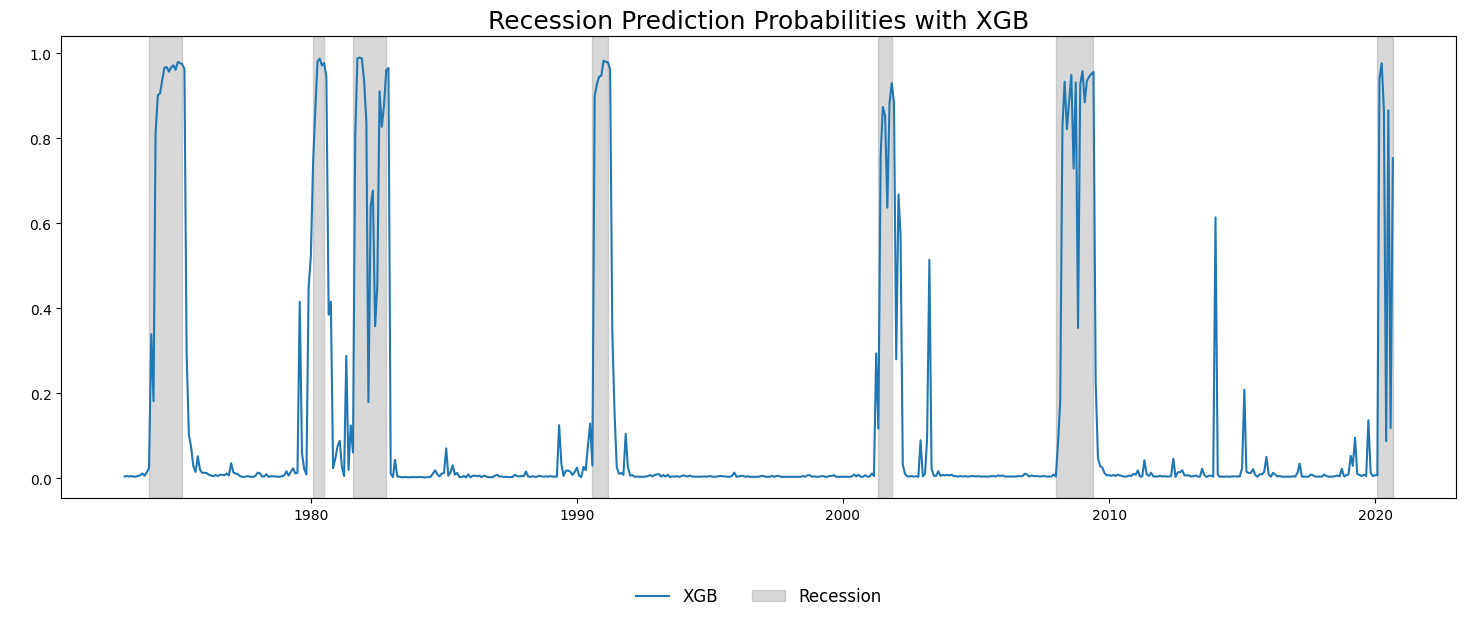

In [11]:
for model in list(model_dict.keys()):
    df = RegimePlot(df = res_rolling_all,regime_col='Regime')
    df.plt_regime(plt_series = [model[0]],series_label = [model[0]],regime_label = 'Recession',orj_series = True,log_scale = False,title = 'Recession Prediction Probabilities with '+model[0])